# Sentiment scorer

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Ticker acquisition

In [3]:
tickers = []

Option 1 - Function for scraping yahoo finance tables

In [4]:
def yahoo_stock_table_scrape(yahoo_tab,table_id):
    stock_table_url = 'https://finance.yahoo.com/' + yahoo_tab
    req = Request(url = stock_table_url, headers = {'user-agent':'my-app'})
    response = urlopen(req)
    html = BeautifulSoup(response, 'html')
    yahoo_table = html.find(id = table_id)
    yahoo_parsed_data = []
    for row in yahoo_table.findAll('tr')[1:]:
        ticker = row.a.text
        yahoo_parsed_data.append(ticker)
    yahoo_tickers = yahoo_parsed_data[:5]
    return yahoo_tickers

Option 2 - User input

In [5]:
for i in range(5):
    ticker = str(input(f'Please input the ticker for stock {i+1}'))
    ticker = [ticker]
    tickers.extend(ticker)
print(tickers)

Please input the ticker for stock 1 AAPL
Please input the ticker for stock 2 AMZN
Please input the ticker for stock 3 TSLA
Please input the ticker for stock 4 GOOGL
Please input the ticker for stock 5 DOD


['AAPL', 'AMZN', 'TSLA', 'GOOGL', 'DOD']


### Finviz news

In [6]:
news_tables = {}

for i, ticker in enumerate(tickers):
    ticker_url = 'https://finviz.com/quote.ashx?t=' + ticker
    req = Request(url = ticker_url, headers = {'user-agent':'my-app'})
    try:
        response = urlopen(req)
    except:
        print(f'{ticker} not available')
    else:
        html = BeautifulSoup(response, 'html')
        news_table = html.find(id = 'news-table')
        news_tables[ticker] = news_table

DOD not available


In [7]:
finviz_parsed_data = []

for ticker, news_table in news_tables.items():
    
    for row in news_table.findAll('tr'):
        title = row.a.text # use get_text instead of text, essentially same thing
        date_data = row.td.text.split(' ') # split on spaces for when it gives us both the date and time
        
        if len(date_data) == 1: # then only have timestamp, and it's greater than 1 then we have data and time
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
            
        finviz_parsed_data.append([ticker, date, time, title])

### Sentiment analyser

In [8]:
df = pd.DataFrame(finviz_parsed_data, columns = ['ticker','date','time','title'])
vader = SentimentIntensityAnalyzer()
df['score'] = df['title'].apply(lambda title : vader.polarity_scores(title)['compound'])
df['date'] = pd.to_datetime(df.date).dt.date # convert string to date type format
df.head()

,ticker,date,time,title,score
0,AAPL,2021-11-15,08:25AM,10 Stocks To Invest In According To Stephen Er...,0.0000
1,AAPL,2021-11-14,10:38PM,Apple TV+ hopes to build on rivals' success wi...,0.7579
2,AAPL,2021-11-14,02:16PM,Apple Working On Privacy Glasses For iPhones T...,-0.4404
3,AAPL,2021-11-14,09:06AM,Top 10 Stock Picks of Donald Sussmans Paloma P...,0.2023
4,AAPL,2021-11-14,06:30AM,H&Ms Tech Chief Wants Clothes to Compete With ...,0.0000


<Figure size 1440x720 with 0 Axes>

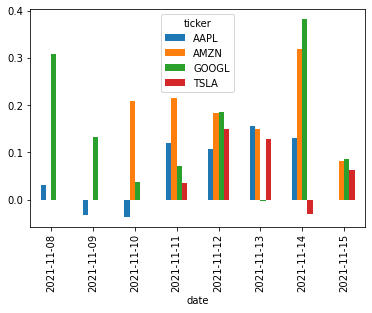

In [9]:
plt.figure(figsize = (20,10))
mean_df = df.groupby(['ticker','date']).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs('score', axis = "columns").transpose()
mean_df.plot(kind = 'bar')
plt.xticks(rotation = 90)
plt.show()